In [7]:
from uproot_io import Events, View
import numpy as np
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

In [4]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\PandoraRecoFile_1.root")

In [5]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def inlierplot(event_number, plot):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    particleType = []
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    if plot == True:
        plt.scatter(vx, vz, c='red', s=50)

    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x0, z0, s=0.5)
        
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)
        
    if vx < xmin:
        xmin = vx    
    if vx > xmax:
        xmax = vx
    if vz < zmin:
        zmin = vz    
    if vz > zmax:
        zmax = vz

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    if plot == True:
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
        plt.show()
        
        plt.scatter(vx, vz, c='red', s=50)
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        
        particleType.append(pdg)
        if pdg == 0:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
        
        else:
            if plot == True:
                plt.scatter(x, z, s=0.5)

            best_inliers = []
            best_model = None
            sample_size = 10
            max_iterations = 1000
            #inlier_threshold = 2.0

            for _ in range(max_iterations):
                sample_size = min(sample_size, len(x))
                sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                x_sample = x[sample_indices]
                z_sample = z[sample_indices]

                m, c = fit_line(x_sample, z_sample)
                residuals = calculate_residuals(x, z, m, c)
                inliers = np.where(residuals < (0.15*xlen))[0]

                if len(inliers) > len(best_inliers):
                    best_inliers = inliers
                    best_model = (m, c)

            if len(best_inliers) > 0:
                m, c = best_model
                gradients.append(m)
                intercepts.append(c)

                if plot == True:
                    x_inliers = x[best_inliers]
                    z_inliers = z[best_inliers]
                    plt.scatter(x_inliers, z_inliers, color='blue', marker='o')

                    plt.plot(x_inliers, m * x_inliers + c)
                    plt.xlabel('x')
                    plt.ylabel('w')

                perp_dist = [calculate_residuals(x[i], z[i], m, c) for i in range(len(x))]
                start = int(0.25 * len(x))
                end = int(start*3)
                mean = np.mean(perp_dist[start:end])
                #mean = np.mean(perp_dist)
                NaN = isnan(mean)
                if NaN == True:
                    resis.append(0)
                if NaN == False:
                    resis.append(mean)
            else:
                gradients.append(1)
                intercepts.append(1)
                resis.append(1)
                #print("No inliers found for a particle")
                continue
    
    if plot == True:
        plt.show()
    
    return np.array(np.stack((gradients, intercepts, resis, particleType)))

In [27]:
import math
#all 0 = unimportant particle
#all 1 = failed fit

def coords(event_number):
    array = inlierplot(event_number, False)
    m = array[0, :]
    c = array[1, :]
    r = array[2, :]
    part = array[3, :]
    
    l = []
    t = []
    residuals = []
    
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        if part[i] == 0 or r[i] == 0 or r[i] == 1:
            residuals.append(0)
            l.append(0)
            t.append(0)
        else:
            x = events.reco_hits_x_w[i+idx[0]]
            z = events.reco_hits_w[i+idx[0]]

            znew = z - c[i]

            angle = -math.atan(m[i])

            lcoords = x * np.cos(angle) - znew * np.sin(angle)
            tcoords = x * np.sin(angle) + znew * np.cos(angle)
            
            l.append(lcoords)
            t.append(tcoords)
            #plt.scatter(lcoords,tcoords)
            #plt.show()
            
            mean = np.mean(abs(tcoords))
            NaN = isnan(mean)
            if NaN == True:
                residuals.append(0)
            if NaN == False:
                residuals.append(mean)
    
    residuals = np.array(residuals)
    return l, t, part, residuals

In [31]:
l, t, p, r = coords(2862)

In [51]:
def connectiondist(event_number):
    totals = []
    parts = []
    
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        x = events.reco_hits_x_w[i+idx[0]]
        z = events.reco_hits_w[i+idx[0]]
        part = events.mc_pdg[i+idx[0]]
        
        if part != 0:
            total_distance = 0.0
            for j in range(len(x) - 1):
                distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                total_distance += distance
            meandist = total_distance/(len(x)-1)
            totals.append(meandist)
            parts.append(part)
    
    return np.array(totals), np.array(parts)

In [ ]:
    totals = []
    parts = []
    for index, i in enumerate(p):
        if i != 0:
            total_distance = 0.0
            x = l[index]
            y = t[index]
            for j in range(len(x) - 1):
                distance = np.sqrt((x[j+1] - x[j])**2 + (y[j+1] - y[j])**2)
                total_distance += distance
            meandist = total_distance/(len(x)-1)
            totals.append(meandist)
            parts.append(p[index])
    return np.array(totals), np.array(parts)

In [52]:
connectiondist(1)

(array([ 3.68077233, -0.        ,  0.55904063,  1.34243729,  0.51520276]),
 array([  22,   22,  211, 2212,   13]))

In [61]:
def histplot(num, extra):
    tracks = []
    showers = []
    shpart = []
    
    for n in range(num):
        total, part = connectiondist(n+extra)
        for i in range(len(total)):
            if total[i] != 0. and total[i] != -0. and total[i] <= 20:
                if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                    showers.append(total[i])
                    shpart.append(part[i])
                else:
                    tracks.append(total[i])
    
    bads = []
    for index, i in enumerate(showers):
        if i <= 1:
            bads.append(shpart[index])
    print(bads)        
    
    
    n_bins = 40
    hist2, bin_edges = np.histogram(showers, bins=n_bins)
    hist1, _ = np.histogram(tracks, bins=bin_edges)

    bin_widths = np.diff(bin_edges)
    
    hist1_normalized = hist1 / len(tracks)
    hist2_normalized = hist2 / len(showers)

    plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
    plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')

    plt.legend()
    plt.show()

[11, 11, 11, 11, 11, 11, 22, 22, 22, 22, -11, -11, 22, 11, 11, 22, 22, 11, 11, 11, 11, 11, 11, 11, -11, 11, 11, 11, 11, 11, 11, 22, 22, 22, 22, 11, 22, 11, 11, 22, 11, 11, 11, 22, 22, 22, 11, -11, 11, 11, 22, 22, 11, 11, 22, 22, 22, 11, -11, 11, 22, 11, 22, 22, 11, 22, 11, 22, 11, 22, 11, 11, -11, 22, 22, 22, 22, -11, 11, 11, 11, 22, 22, 22, 22, 22, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 22, 22, 22, 22, 11, 22, 22, 11, 11, 22, 22, 22, 22, 22, 11, 11, 11, 11, -11, -11, 22, 22, 11, 11, -11, 11, -11, 11, 11, 22, 22, 22, 11, 11, 11, -11, 22, 11, 11, 22, -11, 22, 22, 22, 11, 11, 11, 22, 11, 11, 11, 22, 11, 22, 22, -11, 22, -11, 11, 11, 22, 11, 22, 22, -11, 22, -11, 22, -11, 11, 22, -11, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 11, 22, 22, 22, 22, 22, 22, -11, 22, 22, 22, 22, 22, 22, 22, 22, 11, 22, 22, 22, 22, -11, 22, 22, 11, 22, 22, 22, 11, 22, 22, 22, 22, -11, 22, 22, 22, 22, -11, -11, 22, 22, 22, -11, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 11, 22, 22, 22, 22, 22, 22, 22

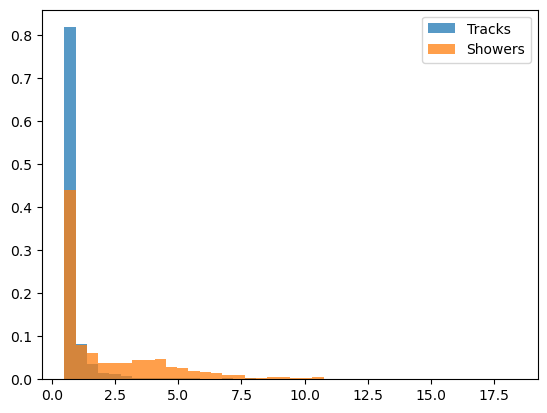

In [62]:
histplot(1000, 763)